# REAL IMPACT OF DWELL TIMES BETWEEN CASH, TOTO, MOBILE APP AND KEYCARD – DA BUSES

# Objective

This project examines how dwell times affect the Route 7 bus service between George Street, Hove, and Brighton Marina in Brighton,UK. Key goals are to understand how different payment methods and ticket types impact dwell times (the time a vehicle spends at a scheduled stop without moving), identify what helps passengers board more efficiently,finding hidden trends and explore ways to improve bus operations.

In [594]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
import missingno as msno # for missing values
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# About dataset & Pre-Processing

This project uses data from the E.P. Morris database (ticketData), Ticketer reporting system (Route_7_Concessionary_data_ticketer) and GPS data (Route_7_GPS_data), covering Route 7 bus operations from **June 4th to June 10th,2023**. The dataset includes records of ticket sales, passenger counts, and key variables like ticket types, payment methods, passenger demographics, dwell times, punctuality, and other operational details. TicketData and Concessionary data are essentially the same and will be combined later. Both will then be joined with GPS data before starting the modeling phase. This data enables a detailed analysis of factors affecting dwell times and boarding efficiency.

In [597]:
Concess= pd.read_excel('Route_7_Concessionary_data_Ticketer.xlsx','Concessionary_Data')
Concess = Concess.rename(columns={'Ticket Time': 'Transaction Time', 'Ticket Class': 'Ticket Description',
                                  'Journey number': 'Trip Number'}) #renaming columns
Concess.head()

,Trip Number,Route number,Operator,Date,Number,Transaction Time,Ticket Description,Fare Paid,Value of Ride,Origin Stage,Destination Stage,Driver number,Bus number,Duty number,Shadow,Custom Formula
0,259,7,0,2023-06-04,1,00:00:00,Adult TOTO,0.0,0,251,273.0,7325,487,2708,2.0,NaN
1,262,7,0,2023-06-04,1,00:01:01,BH Ovr60 ENCTS,0.0,0,251,NaN,6273,351,2714,0.0,NaN
2,262,7,0,2023-06-04,1,00:01:05,Adult TOTO,0.0,0,251,203.0,6273,351,2714,2.0,NaN
3,262,7,0,2023-06-04,1,00:01:12,Adult TOTO,0.0,0,251,203.0,6273,351,2714,2.0,NaN
4,264,7,0,2023-06-04,1,00:01:16,M_Adult NtwkSvr,0.0,0,132,NaN,7151,829,2730,0.0,NaN


In [598]:
ticketer = pd.read_csv('ticketData.csv',encoding='Latin1') #reading the files

ticketer = ticketer.rename(columns={'Op Date': 'Date', 'Bus Stop Name': 'Bus Stop'}) # renaming the columns
ticketer['Date'] = pd.to_datetime(ticketer['Date'], format='%d/%m/%Y') # Convert the column to datetime objects
ticketer['Date'] = ticketer['Date'].dt.strftime('%Y-%m-%d') # Format datetime objects with day and month swapped
ticketer.head() 

,ETM Route Code,Bus Stop,Date,Transaction Time,Ticket Class Description,Trip Number,Ticket Description,Net,Tickets,Pass,Conc,Passengers
0,7,Arundel Road,2023-06-04,05:23:30,Autoscan,1,Adult TOTO,0.0,1,0,0,1
1,7,Arundel Road,2023-06-04,05:23:34,Autoscan,1,Adult TOTO,0.0,1,0,0,1
2,7,Arundel Road,2023-06-04,05:23:36,QR,1,M_Adult CitySvr,0.0,0,1,0,1
3,7,Arundel Road,2023-06-04,05:25:00,Smart,1,BH Ovr60 ENCTS,0.0,0,0,1,1
4,7,Arundel Road,2023-06-04,05:25:06,Autoscan,1,Adult TOTO,0.0,1,0,0,1


In [599]:
ticketer.drop_duplicates()

,ETM Route Code,Bus Stop,Date,Transaction Time,Ticket Class Description,Trip Number,Ticket Description,Net,Tickets,Pass,Conc,Passengers
0,7,Arundel Road,2023-06-04,05:23:30,Autoscan,1,Adult TOTO,0.0,1,0,0,1
1,7,Arundel Road,2023-06-04,05:23:34,Autoscan,1,Adult TOTO,0.0,1,0,0,1
2,7,Arundel Road,2023-06-04,05:23:36,QR,1,M_Adult CitySvr,0.0,0,1,0,1
3,7,Arundel Road,2023-06-04,05:25:00,Smart,1,BH Ovr60 ENCTS,0.0,0,0,1,1
4,7,Arundel Road,2023-06-04,05:25:06,Autoscan,1,Adult TOTO,0.0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
76004,7,Wilbury Villas,2023-06-10,21:17:31,Autoscan,232,Adult TOTO,0.0,1,0,0,1
76005,7,Wilbury Villas,2023-06-10,21:29:14,Autoscan,236,Adult TOTO,0.0,1,0,0,1
76006,7,Wilbury Villas,2023-06-10,22:34:09,Autoscan,248,Adult TOTO,0.0,1,0,0,1
76007,7,Wilbury Villas,2023-06-10,22:34:13,QR,248,M_Adult NtwkSvr,0.0,0,1,0,1


In [600]:
GPS = pd.read_excel('Route_7_GPS_Data.xlsx')
GPS = GPS.rename(columns={'Rec Vehicle No': 'Bus number','Unnamed: 5': 'Timing Point', 'Unnamed: 8': 'Bus Stop'}) # renaming columns
GPS.head() 

,Block_No,Route_No,Route_Desc,Pattern_No,Direction,Timing Point,Bus number,Location No,Bus Stop,Date,Planned Arrival Time,Planned Departure Time,Actual Arrival Time,Actual Departure Time
0,501,7,7,1,1,Timing Point,322,756(0),Brighton Marina,2023-06-04,05:20:00,05:20:00,05:20:05,05:20:05
1,501,7,7,1,1,Timing Point,322,428(0),Arundel Road Btn,2023-06-04,05:22:00,05:22:00,05:22:11,05:22:40
2,501,7,7,1,1,NonTiming Point,322,427(1),Lidl Superstore,2023-06-04,05:22:23,05:22:23,05:22:56,05:23:01
3,501,7,7,1,1,NonTiming Point,322,437(0),Sussex Square,2023-06-04,05:23:04,05:23:04,05:23:19,05:23:51
4,501,7,7,1,1,NonTiming Point,322,426(1),St Marys Hall,2023-06-04,05:23:48,05:23:48,05:24:11,05:24:15


In [601]:
GPS.drop_duplicates()

,Block_No,Route_No,Route_Desc,Pattern_No,Direction,Timing Point,Bus number,Location No,Bus Stop,Date,Planned Arrival Time,Planned Departure Time,Actual Arrival Time,Actual Departure Time
0,501,7,7,1,1,Timing Point,322,756(0),Brighton Marina,2023-06-04,05:20:00,05:20:00,05:20:05,05:20:05
1,501,7,7,1,1,Timing Point,322,428(0),Arundel Road Btn,2023-06-04,05:22:00,05:22:00,05:22:11,05:22:40
2,501,7,7,1,1,NonTiming Point,322,427(1),Lidl Superstore,2023-06-04,05:22:23,05:22:23,05:22:56,05:23:01
3,501,7,7,1,1,NonTiming Point,322,437(0),Sussex Square,2023-06-04,05:23:04,05:23:04,05:23:19,05:23:51
4,501,7,7,1,1,NonTiming Point,322,426(1),St Marys Hall,2023-06-04,05:23:48,05:23:48,05:24:11,05:24:15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40721,714,7,7,1,1,NonTiming Point,833,637(1),Holland Road,2023-06-10,23:37:43,23:37:43,23:37:05,23:37:08
40722,714,7,7,1,1,NonTiming Point,833,636(1),Wilbury Villas,2023-06-10,23:38:16,23:38:16,23:37:24,23:37:49
40723,714,7,7,1,1,NonTiming Point,833,679(0),Eaton Gardens,2023-06-10,23:39:17,23:39:17,23:38:39,23:39:04
40724,714,7,7,1,1,Timing Point,833,680(1),Hove Station,2023-06-10,23:41:00,23:41:00,23:39:49,23:40:14


# Approach

The approach begins with descriptive statistics to summarize key characteristics of the data, followed by exploratory data analysis (EDA) to uncover patterns and relationships among variables. Statistical and machine learning models, including regression, probabilistic models, and advanced AI techniques like decision trees and neural networks, will be used to predict dwell times based on factors such as payment methods and ticket types. These models will help identify significant predictors and improve understanding of the factors influencing boarding efficiency.

# Descriptive Analysis

In [606]:
ticketer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76009 entries, 0 to 76008
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ETM Route Code            76009 non-null  int64  
 1   Bus Stop                  76009 non-null  object 
 2   Date                      76009 non-null  object 
 3   Transaction Time          76009 non-null  object 
 4   Ticket Class Description  76009 non-null  object 
 5   Trip Number               76009 non-null  int64  
 6   Ticket Description        76009 non-null  object 
 7   Net                       76009 non-null  float64
 8   Tickets                   76009 non-null  int64  
 9   Pass                      76009 non-null  int64  
 10  Conc                      76009 non-null  int64  
 11  Passengers                76009 non-null  int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 7.0+ MB


In [607]:
ticketer.describe().T

,count,mean,std,min,25%,50%,75%,max
ETM Route Code,76009.0,7.000000,0.000000,7.0,7.0,7.0,7.0,7.0
Trip Number,76009.0,140.946348,95.647448,1.0,76.0,138.0,194.0,1456.0
Net,76009.0,0.199891,0.888686,-36.0,0.0,0.0,0.0,36.0
Tickets,76009.0,0.402426,0.550958,-9.0,0.0,0.0,1.0,15.0
Pass,76009.0,0.394795,0.551750,0.0,0.0,0.0,1.0,33.0
Conc,76009.0,0.229473,0.420559,0.0,0.0,0.0,0.0,2.0
Passengers,76009.0,1.026694,0.318137,-9.0,1.0,1.0,1.0,33.0


In [608]:
ticketer.describe(include='object').T

,count,unique,top,freq
Bus Stop,76009,37,Brighton Marina,7970
Date,76009,7,2023-06-07,12335
Transaction Time,76009,43071,14:35:14,9
Ticket Class Description,76009,11,Smart,25992
Ticket Description,76009,65,Adult TOTO,22468


The descriptive statistics for the ticket data reveal insights into various aspects of passenger
transactions. The dataset consists of 76,009 entries across 12 columns. Notably, the most frequent bus
stop recorded is "Brighton Marina," accounting for 7,970 instances. Transaction times span 43,071
unique values, with the most common time being "14:35:14," occurring 9 times. Regarding ticket class
descriptions, "Smart" tickets are predominant, comprising 25,992 entries, followed by other ticket
types. However, anomalies such as negative values are observed in some variables, suggesting potential
data issues requiring attention before the exploratory analysis phase. The statistics provide a
comprehensive overview of ticketing patterns, including trip numbers, net transactions, ticket counts,
pass counts, concurrence counts, and passenger counts, offering valuable insights into passenger
behaviour and ticket usage.

In [610]:
GPS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40726 entries, 0 to 40725
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Block_No                40726 non-null  int64         
 1   Route_No                40726 non-null  int64         
 2   Route_Desc              40726 non-null  int64         
 3   Pattern_No              40726 non-null  int64         
 4   Direction               40726 non-null  int64         
 5   Timing Point            40726 non-null  object        
 6   Bus number              40726 non-null  int64         
 7   Location No             40726 non-null  object        
 8   Bus Stop                40726 non-null  object        
 9   Date                    40726 non-null  datetime64[ns]
 10  Planned Arrival Time    40726 non-null  object        
 11  Planned Departure Time  40726 non-null  object        
 12  Actual Arrival Time     40726 non-null  object

In [611]:
GPS.describe()

,Block_No,Route_No,Route_Desc,Pattern_No,Direction,Bus number,Date
count,40726.000000,40726.0,40726.0,40726.000000,40726.000000,40726.000000,40726
mean,705.874527,7.0,7.0,50.439228,1.499386,739.878554,2023-06-06 23:21:02.112655616
min,501.000000,7.0,7.0,1.000000,1.000000,307.000000,2023-06-04 00:00:00
25%,703.000000,7.0,7.0,1.000000,1.000000,825.000000,2023-06-05 00:00:00
50%,707.000000,7.0,7.0,1.000000,1.000000,830.000000,2023-06-07 00:00:00
75%,710.000000,7.0,7.0,100.000000,2.000000,834.000000,2023-06-09 00:00:00
max,714.000000,7.0,7.0,100.000000,2.000000,840.000000,2023-06-10 00:00:00
std,14.627603,0.0,0.0,49.500570,0.500006,183.257257,NaN


In [612]:
GPS.describe(include='object')

,Timing Point,Location No,Bus Stop,Planned Arrival Time,Planned Departure Time,Actual Arrival Time,Actual Departure Time
count,40726,40726,40726,40726,40726,40726,40726
unique,2,52,38,11111,11111,30532,30515
top,NonTiming Point,679(0),North Road,11:42:00,11:42:00,11:04:54,13:17:16
freq,28716,1513,1516,32,32,6,6


The descriptive analysis of the GPS data provides insights into the operational aspects of the
bus service. The dataset comprises 40,726 entries across 14 columns, detailing information such as block
numbers, route numbers, patterns, directions, and bus numbers. Notably, the mean block number is
approximately 705.87, with a standard deviation of 14.63. The route description and pattern number
indicate uniformity, with all entries having the same values. The direction column suggests that most
entries have a direction value close to 1. The timing point column reveals that the majority of entries are
non-timing points, indicating potential variability in bus stop classifications. Regarding bus stops, "North
Road" appears to be the most frequent, occurring 1,516 times. However, it's notable that anomalies
such as "NonTiming Point" entries and non-uniform timing point frequencies are observed. Additionally,
planned and actual arrival/departure times exhibit variability, with some instances occurring more
frequently than others. These findings highlight the need for further exploration and data preprocessing
to address anomalies and ensure data consistency before further analysis.

# Exploratory Data Analysis

In [615]:
df = ticketer.sort_values(by=["Date","Trip Number","Transaction Time"], ignore_index=True)

## Passengers each date?

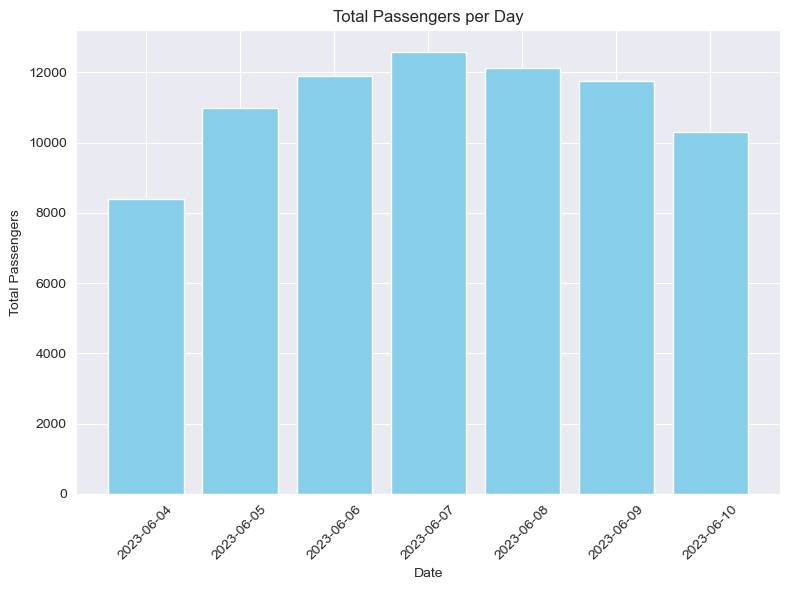

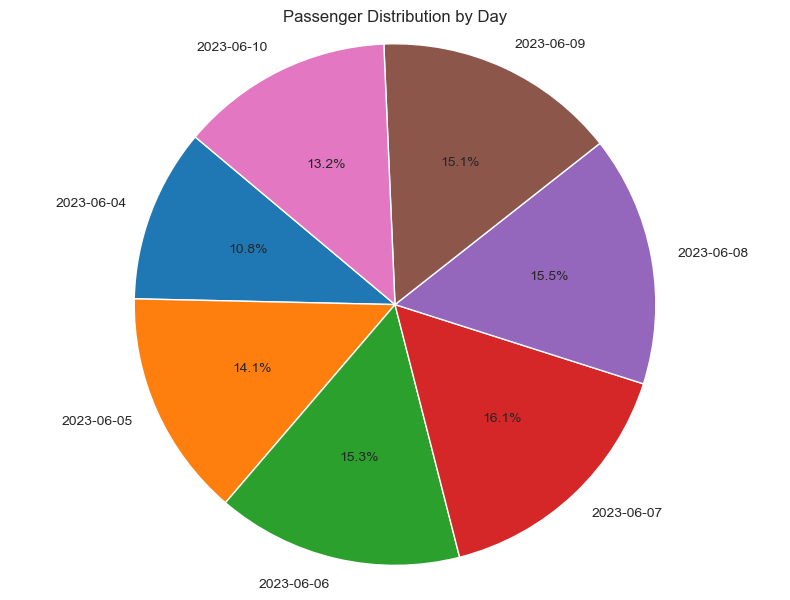

In [617]:
#bar chart
# Group by 'Date' and sum the 'Passengers' for each day
daily_passengers = df.groupby('Date')['Passengers'].sum().reset_index()


# Plot a bar chart of the total passengers for each day
plt.figure(figsize=(8, 6))
plt.bar(daily_passengers['Date'], daily_passengers['Passengers'], color='skyblue')
plt.xlabel('Date')
plt.ylabel('Total Passengers')
plt.title('Total Passengers per Day')
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to ensure everything fits without overlap
plt.show()


#pie chart
plt.figure(figsize=(8, 6))
plt.pie(daily_passengers['Passengers'], labels=daily_passengers['Date'], autopct='%1.1f%%', startangle=140)
plt.title('Passenger Distribution by Day')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the pie chart
plt.tight_layout()
plt.show()

 #### 04/06/2023 has seen lowest passenger uses. Interesting to notice that this was Sunday.


## Which ticket type is most popular?

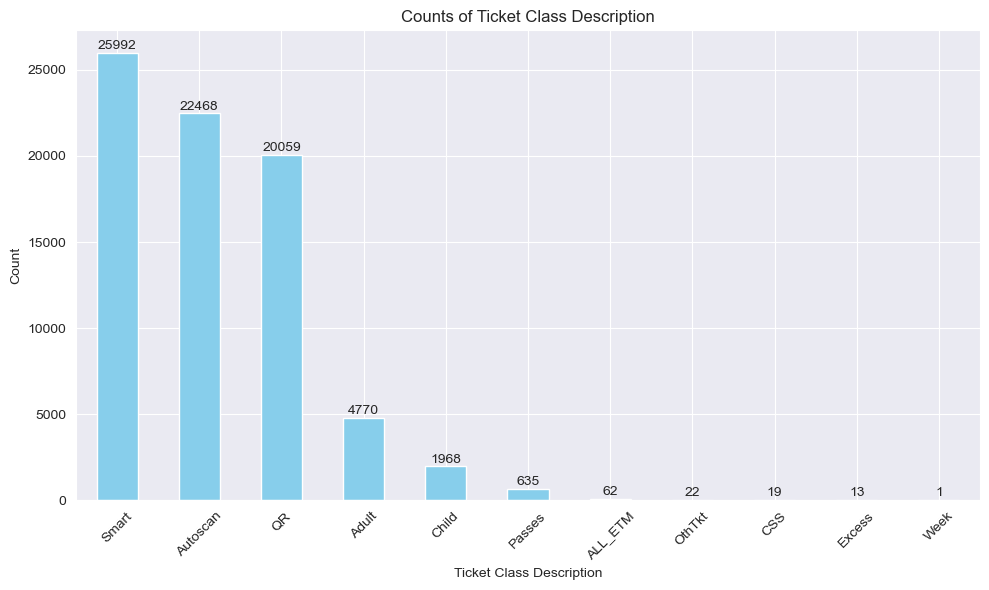

In [620]:

ticket_counts = df['Ticket Class Description'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
bars = ticket_counts.plot(kind='bar', color='skyblue')

# Add counts on top of bars
for bar in bars.patches:
    plt.annotate(format(bar.get_height(), '.0f'), 
                 (bar.get_x() + bar.get_width() / 2, 
                  bar.get_height()), 
                 ha='center', va='center', 
                 xytext=(0, 5), 
                 textcoords='offset points')

plt.xlabel('Ticket Class Description')
plt.ylabel('Count')
plt.title('Counts of Ticket Class Description')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from getting cut off
plt.show()


#### 'Smart' Tickets are the most popular among the 11 ticket types from 04/06/2023 to 10/06/2023. 'Smart' with 'Autoscan' and 'QR'  are three predominant tickets.


### Let us find out the popularities of the sub-category of the ticket types.

In [623]:
df2 = df.groupby('Ticket Class Description')

for name, group in df2:
    print("Ticket Class:", name)
    print(group[['Ticket Description']].value_counts())
    print("\n")

Ticket Class: ALL_ETM
Ticket Description
Credit                54
Punch                  8
Name: count, dtype: int64


Ticket Class: Adult
Ticket Description
Adult Single          3995
Adult CitySaver        766
Adult NetwkSaver         9
Name: count, dtype: int64


Ticket Class: Autoscan
Ticket Description
Adult TOTO            22468
Name: count, dtype: int64


Ticket Class: CSS
Ticket Description
Ad CSS+NtwkSvr        10
Con/Stu CSS+NwkS       9
Name: count, dtype: int64


Ticket Class: Child
Ticket Description
Child Single          1076
BH/ES Ch Sgl Accom     798
Child CitySaver         62
Child Unpaid            28
Child NwkSaver           4
Name: count, dtype: int64


Ticket Class: Excess
Ticket Description
Excess 10p            5
Excess £1             4
Excess 50p            3
Excess 5p             1
Name: count, dtype: int64


Ticket Class: OthTkt
Ticket Description
Family NwkSaver       22
Name: count, dtype: int64


Ticket Class: Passes
Ticket Description
Pass                 

# Which payment method is quicker or slower? What is the average transaction time of different ticket types?

To derive this, first transaction time for each ticket type in seconds is calculated. A new column
called 'T_time' (in seconds) is created by grouping the ticket data by 'Bus Stop', 'Trip Number', and
'Date', and then subtracting their subsequent 'Transaction Time' values from each other. Note that
'Transaction Time' refers to the actual recorded time, while 'T_time' represents the overall time taken
by a ticket type

In [626]:
# Make a copy of the original DataFrame
df3 = df.copy()

# Convert 'Transaction Time' column to datetime
df3['Transaction Time'] = pd.to_datetime(df3['Transaction Time'])

# Calculate the time difference between consecutive rows
df3['T_time'] = df3.groupby(['Bus Stop', 'Date', 'Trip Number'])['Transaction Time'].diff().dt.total_seconds().fillna(0)

# Convert the 'Transaction Time' column back to time format
df3['Transaction Time'] = df3['Transaction Time'].dt.time

# Print the DataFrame head to check the results
df3.head()


C:\Users\ashra\AppData\Local\Temp\ipykernel_15144\3868632333.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df3['Transaction Time'] = pd.to_datetime(df3['Transaction Time'])


,ETM Route Code,Bus Stop,Date,Transaction Time,Ticket Class Description,Trip Number,Ticket Description,Net,Tickets,Pass,Conc,Passengers,T_time
0,7,Brighton Marina,2023-06-04,05:15:59,QR,1,M_Adult CitySvr,0.0,0,1,0,1,0.0
1,7,Brighton Marina,2023-06-04,05:16:09,Autoscan,1,Adult TOTO,0.0,1,0,0,1,10.0
2,7,Brighton Marina,2023-06-04,05:16:23,Smart,1,BH Disab ENCTS,0.0,0,0,1,1,14.0
3,7,Brighton Marina,2023-06-04,05:19:32,QR,1,M_Stu NtwkSaver,0.0,0,1,0,1,189.0
4,7,Brighton Marina,2023-06-04,05:19:36,QR,1,M_Stu NtwkSaver,0.0,0,1,0,1,4.0


In [627]:
df3['T_time'].describe().T

count    76009.000000
mean         8.805655
std        319.759950
min          0.000000
25%          0.000000
50%          4.000000
75%          6.000000
max      86304.000000
Name: T_time, dtype: float64

Clearly, there are some extreme observations, as the maximum value is 86,304, which is very high. To id
entify these large data points, the column was filtered using the mean plus the standard deviation of the
column. A total of 55 such observations were found and subsequently removed from the data.

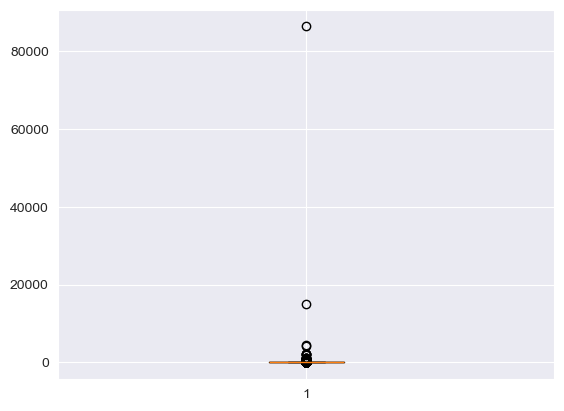

In [629]:
plt.boxplot(df3['T_time'])
plt.show()

In [630]:
#Transaction time anomalies detection
# Calculate mean and standard deviation
mean_T_time = df3['T_time'].mean()
std_T_time = df3['T_time'].std()

# Define threshold for anomalies
threshold =  std_T_time

# Find anomalies
anomalies = df3[df3['T_time'] > mean_T_time + threshold]

# Print the number of anomalies
print("Number of anomalies:", len(anomalies))

print("Time of anomalies:")
print(anomalies[['Bus Stop','Transaction Time','T_time']])


Number of anomalies: 55
Time of anomalies:
                         Bus Stop Transaction Time   T_time
5639       George Street (stop J)         17:07:00    332.0
5758       George Street (stop J)         17:17:06    337.0
7131       George Street (stop J)         20:06:14    494.0
8192       George Street (stop J)         06:32:49    423.0
10317               Eaton Gardens         10:02:10    341.0
11898   Brighton Station (stop E)         13:17:01   2107.0
14135      George Street (stop J)         15:08:47    376.0
17328                Hove Station         19:04:50    778.0
18781      George Street (stop J)         05:19:05    412.0
21098                Arundel Road         09:53:24    338.0
24421             Brighton Marina         18:25:30  15061.0
24913                Hove Station         15:38:52    792.0
24915               Eaton Gardens         15:42:30   1090.0
24923   Brighton Station (stop E)         15:50:41   2175.0
27394              Chesham Street         17:31:45    393

In [631]:
#Dropping the 'Transaction time' anomalies
# Calculate mean and standard deviation
mean_T_time = df3['T_time'].mean()
std_T_time = df3['T_time'].std()

# Define threshold for anomalies
threshold = std_T_time

# Find indices of anomalies
anomalies = df3[df3['T_time'] > mean_T_time + threshold].index

# Drop rows with anomalies
df3.drop(index=anomalies, inplace=True)

# Print the updated DataFrame information
print("Number of rows after dropping anomalies:", len(df3))


Number of rows after dropping anomalies: 75954


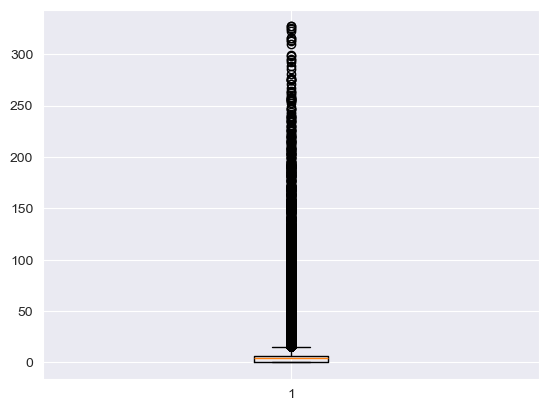

In [632]:
plt.boxplot(df3['T_time'])
plt.show()

After this, the total transaction time for each type of ticket was calculated. Then, the total transaction
time was divided by the total count of each ticket type to find the average transaction time.

In [634]:
# Group by 'Ticket Description' and calculate average time
total_time_and_count_by_class = df3.groupby('Ticket Class Description')['T_time'].agg(['sum', 'count']).abs().reset_index()
total_time_and_count_by_class.rename(columns={'sum': 'Total Time', 'count': 'Ticket Count'}, inplace=True)

# Calculate average time
total_time_and_count_by_class['Average Time'] = total_time_and_count_by_class['Total Time'] / total_time_and_count_by_class['Ticket Count']


print("Average time by Ticket Class Description:")
print(total_time_and_count_by_class)


Average time by Ticket Class Description:
   Ticket Class Description  Total Time  Ticket Count  Average Time
0                   ALL_ETM       432.0            62      6.967742
1                     Adult     62815.0          4763     13.188117
2                  Autoscan    142595.0         22454      6.350539
3                       CSS       173.0            19      9.105263
4                     Child     20302.0          1967     10.321301
5                    Excess       112.0            13      8.615385
6                    OthTkt       625.0            21     29.761905
7                    Passes      7026.0           635     11.064567
8                        QR    112922.0         20048      5.632582
9                     Smart    176073.0         25971      6.779600
10                     Week         0.0             1      0.000000


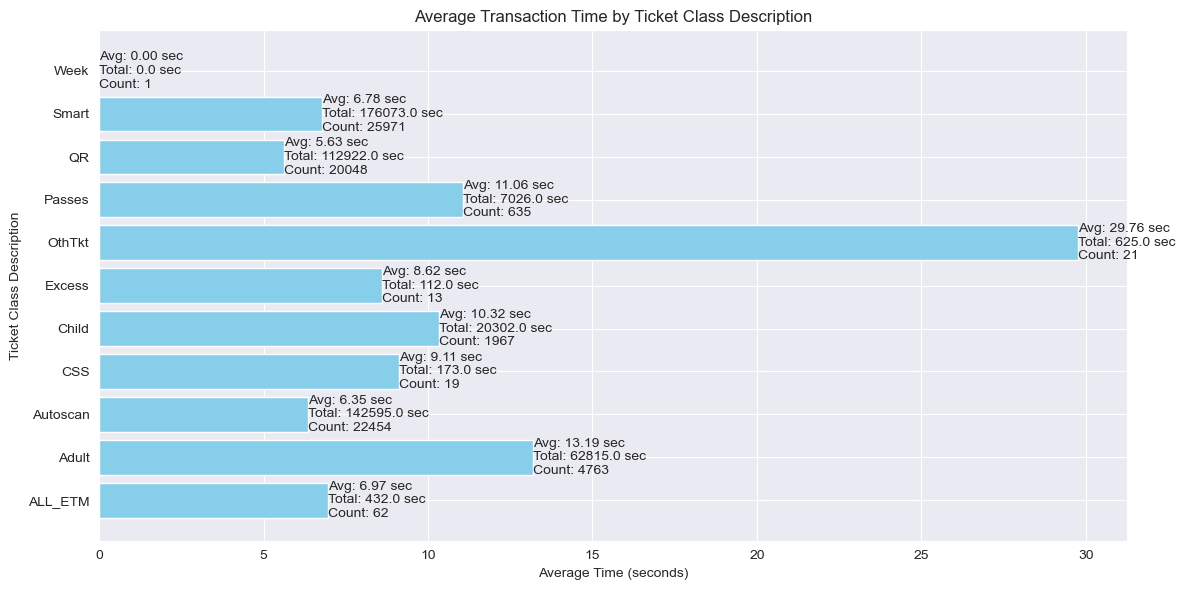

In [635]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by 'Ticket Class Description' and calculate average time
total_time_and_count_by_class = df3.groupby('Ticket Class Description')['T_time'].agg(['sum', 'count']).abs().reset_index()
total_time_and_count_by_class.rename(columns={'sum': 'Total Time', 'count': 'Ticket Count'}, inplace=True)

# Calculate average time
total_time_and_count_by_class['Average Time'] = total_time_and_count_by_class['Total Time'] / total_time_and_count_by_class['Ticket Count']

plt.figure(figsize=(12, 6))
bars = plt.barh(total_time_and_count_by_class['Ticket Class Description'], total_time_and_count_by_class['Average Time'], color='skyblue')
plt.ylabel('Ticket Class Description')
plt.xlabel('Average Time (seconds)')
plt.title('Average Transaction Time by Ticket Class Description')

# Add the average time, total time, and ticket count labels on the bars
for index, bar in enumerate(bars):
    plt.text(
        bar.get_width(),  # x-coordinate position of the text
        bar.get_y() + bar.get_height() / 2,  # y-coordinate position of the text
        f'Avg: {bar.get_width():.2f} sec\nTotal: {total_time_and_count_by_class["Total Time"].iloc[index]} sec\nCount: {total_time_and_count_by_class["Ticket Count"].iloc[index]}',  # text to display (formatted to 2 decimal places)
        va='center',  # vertical alignment
        ha='left',  # horizontal alignment
        fontsize=10  # font size
    )

plt.tight_layout()  # Adjust layout to ensure everything fits without overlap
plt.show()


Examining the average transaction time for each ticket type provided insights into transaction efficiency
and processing durations. For instance, 'QR' tickets exhibited the shortest average transaction time,
while 'OthTkt' and 'Adult' tickets had comparatively longer transaction durations. Although, ‘Smart’
14
ticket has third lowest ticket time, interesting to note that, it has the highest ticket counts among all.
Understanding transaction time variations among ticket types can inform strategies to streamline
ticketing processes and reduce passenger wait times.


# How long the buses are at each stop for and what tickets were being used?

While extracting dwell time from the GPS dataset, issues with 'Actual Arrival Time' and 'Actual Departure Time' were found due to inconsistent datetime formats. These anomalies were corrected, and dwell times were then calculated for each bus stop.

In [639]:
GPS_df=GPS.copy()

# Function to check anomalies
def check_anomalies(column):
    anomalies = []
    for value in column:
        value_str = str(value)
        if len(value_str) != 8:  # Check if the length of the string representation is not equal to 'HH:MM:SS'
            anomalies.append(value_str)
    return anomalies

# Check anomalies in 'Actual Arrival Time'
arrival_anomalies = check_anomalies(GPS_df['Actual Arrival Time'])

# Check anomalies in 'Actual Departure Time'
departure_anomalies = check_anomalies(GPS_df['Actual Departure Time'])

print("Anomalies in Actual Arrival Time:", arrival_anomalies)
print("Anomalies in Actual Departure Time:", departure_anomalies)


Anomalies in Actual Arrival Time: ['1900-01-01 00:00:18', '1900-01-01 00:01:36', '1900-01-01 00:02:27', '1899-12-29 23:59:41', '1900-01-01 00:00:44', '1900-01-01 00:02:33', '1899-12-29 23:59:35', '1900-01-01 00:00:40', '1900-01-01 00:01:23', '1899-12-29 23:57:59', '1899-12-29 23:59:55', '1900-01-01 00:00:30', '1899-12-29 23:59:59', '1899-12-29 23:59:53', '1900-01-01 00:00:18', '1899-12-29 23:58:11', '1900-01-01 00:00:23', '1899-12-29 23:59:49', '1899-12-29 23:59:35', '1899-12-29 23:59:39', '1899-12-29 23:57:05', '1899-12-29 23:58:35', '1899-12-29 23:59:55', '1899-12-29 23:59:37', '1899-12-29 23:59:58', '1900-01-01 00:01:07', '1899-12-29 23:58:19', '1900-01-01 00:00:07', '1900-01-01 00:00:55', '1900-01-01 00:01:57', '1900-01-01 00:03:27', '1900-01-01 00:03:23']
Anomalies in Actual Departure Time: ['1900-01-01 00:00:46', '1900-01-01 00:02:12', '1900-01-01 00:02:31', '1899-12-29 23:59:41', '1900-01-01 00:01:28', '1900-01-01 00:03:07', '1900-01-01 00:01:27', '1900-01-01 00:00:01', '1900-01

In [640]:
# Function to check anomalies and convert datetime to time format
def convert_anomalies_to_time_format(df):
    for col in ['Actual Arrival Time', 'Actual Departure Time']:
        for idx, value in enumerate(df[col]):
            value_str = str(value)
            if len(value_str) != 8:  # Check if the length of the string representation is not equal to 'HH:MM:SS'
                df.at[idx, col] = value_str.split()[1]  # Extract only the time part

# Create a copy of the original DataFrame to avoid modifying it
GPS_df = GPS.copy()

# Convert anomalies in 'Actual Arrival Time' and 'Actual Departure Time' columns to time format
convert_anomalies_to_time_format(GPS_df)

# Print the modified DataFrame
print(GPS_df)


       Block_No  Route_No  Route_Desc  Pattern_No  Direction     Timing Point  \
0           501         7           7           1          1     Timing Point   
1           501         7           7           1          1     Timing Point   
2           501         7           7           1          1  NonTiming Point   
3           501         7           7           1          1  NonTiming Point   
4           501         7           7           1          1  NonTiming Point   
...         ...       ...         ...         ...        ...              ...   
40721       714         7           7           1          1  NonTiming Point   
40722       714         7           7           1          1  NonTiming Point   
40723       714         7           7           1          1  NonTiming Point   
40724       714         7           7           1          1     Timing Point   
40725       714         7           7           1          1  NonTiming Point   

       Bus number Location 

In [641]:

# Function to check anomalies
def check_anomalies(column):
    anomalies = []
    for value in column:
        value_str = str(value)
        if len(value_str) != 8:  # Check if the length of the string representation is not equal to 'HH:MM:SS'
            anomalies.append(value_str)
    return anomalies

# Check anomalies in 'Actual Arrival Time'
arrival_anomalies = check_anomalies(GPS_df['Actual Arrival Time'])

# Check anomalies in 'Actual Departure Time'
departure_anomalies = check_anomalies(GPS_df['Actual Departure Time'])

print("Anomalies in Actual Arrival Time:", arrival_anomalies)
print("Anomalies in Actual Departure Time:", departure_anomalies)



Anomalies in Actual Arrival Time: []
Anomalies in Actual Departure Time: []


In [642]:

#GPS_df['Actual Arrival Time'] = pd.to_datetime(GPS_df['Actual Arrival Time'])
#GPS_df['Actual Departure Time'] = pd.to_datetime(GPS_df['Actual Departure Time'])

GPS_df['Actual Arrival Time'] = pd.to_datetime(GPS_df['Actual Arrival Time'], format='%H:%M:%S')
GPS_df['Actual Departure Time'] = pd.to_datetime(GPS_df['Actual Departure Time'], format='%H:%M:%S')

# Calculate the time spent at each stop in seconds
GPS_df['Dwell time'] = GPS_df.apply(lambda row: (row['Actual Departure Time'].hour * 3600 + row['Actual Departure Time'].minute * 60 + row['Actual Departure Time'].second) -
                                                             (row['Actual Arrival Time'].hour * 3600 + row['Actual Arrival Time'].minute * 60 + row['Actual Arrival Time'].second) if row['Actual Departure Time'] >= row['Actual Arrival Time'] else
                                                             (row['Actual Departure Time'].hour * 3600 + row['Actual Departure Time'].minute * 60 + row['Actual Departure Time'].second + 24*3600) -
                                                             (row['Actual Arrival Time'].hour * 3600 + row['Actual Arrival Time'].minute * 60 + row['Actual Arrival Time'].second), axis=1)

# Display the dataframe
print(GPS_df)


       Block_No  Route_No  Route_Desc  Pattern_No  Direction     Timing Point  \
0           501         7           7           1          1     Timing Point   
1           501         7           7           1          1     Timing Point   
2           501         7           7           1          1  NonTiming Point   
3           501         7           7           1          1  NonTiming Point   
4           501         7           7           1          1  NonTiming Point   
...         ...       ...         ...         ...        ...              ...   
40721       714         7           7           1          1  NonTiming Point   
40722       714         7           7           1          1  NonTiming Point   
40723       714         7           7           1          1  NonTiming Point   
40724       714         7           7           1          1     Timing Point   
40725       714         7           7           1          1  NonTiming Point   

       Bus number Location 

In [643]:
GPS_df['Dwell time'].describe()

count    40726.000000
mean        44.940456
std         67.852695
min          0.000000
25%         14.000000
50%         31.000000
75%         50.000000
max       3223.000000
Name: Dwell time, dtype: float64

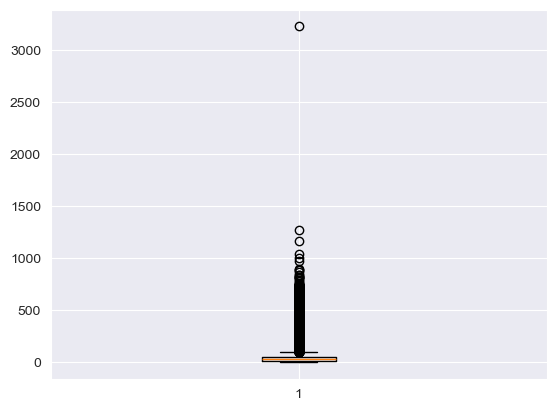

In [644]:
plt.boxplot(GPS_df['Dwell time'])
plt.show()

In [645]:

# Calculate mean and standard deviation
mean_T_time =GPS_df['Dwell time'].mean()
std_T_time = GPS_df['Dwell time'].std()

# Define threshold for anomalies
threshold =  3*std_T_time

# Find anomalies
anomalies = GPS_df[GPS_df['Dwell time'] > mean_T_time + threshold]

# Print the number of anomalies
print("Number of anomalies:", len(anomalies))

print("Time of anomalies:")
print(anomalies[['Bus Stop','Dwell time']])



Number of anomalies: 618
Time of anomalies:
               Bus Stop  Dwell time
296    George Street HJ         367
350    George Street HJ         740
404    George Street HJ         315
445    George Street HJ         452
499    George Street HJ         562
...                 ...         ...
40457  George Street HJ         265
40511  George Street HJ         255
40565  George Street HJ         813
40618  George Street HJ         296
40672  George Street HJ         559

[618 rows x 2 columns]


In [646]:
# Count the number of observations where 'Dwell time' is greater than 400 seconds
anomalies = len(GPS_df[GPS_df['Dwell time'] >= 700])

print(anomalies)


51


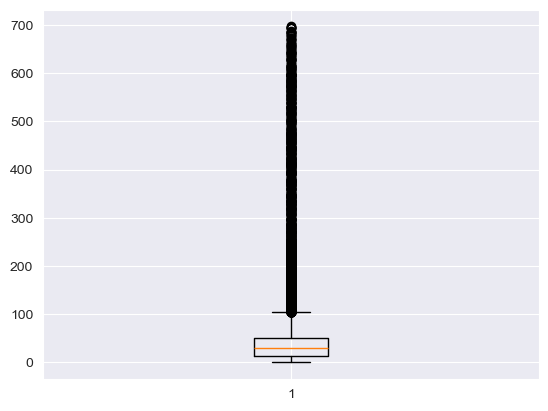

In [647]:
# Filter rows where 'Dwell time' is greater than or equal to your desirable seconds
rows_to_delete = GPS_df[GPS_df['Dwell time'] >= 700]

# Drop the filtered rows from the original DataFrame
GPS_df = GPS_df.drop(rows_to_delete.index)

# Optional: Reset the index of the DataFrame after dropping rows
GPS_df = GPS_df.reset_index(drop=True)

# Display the updated DataFrame
plt.boxplot(GPS_df['Dwell time'])
plt.show()

## Time spent at each stop by the buses.

In [649]:
# Group by 'Bus Stop' and sum the 'Dwell time'
total_time_spent_by_location = GPS_df.groupby('Bus Stop')['Dwell time'].sum().sort_values(ascending=False)

# Display the result
print(total_time_spent_by_location)

Bus Stop
George Street HJ              247966
Brighton Station A             87297
Hove Station                   72749
North Street C                 71830
Clock Tower (stop N)           71115
County Hospital                70602
Brighton Station E             64575
North Road                     60072
Clock Tower                    58586
North Street X                 55925
Eaton Gardens                  53452
St James's St.                 51825
Lyon Close                     50340
Bottom of Montefiore Road      50035
Wilbury Villas                 47909
Upper Bedford Street           46644
Old Steine U                   46457
The Waterfront                 43797
Arundel Road Btn               42817
Park Street                    42412
Lidl Superstore                41724
Roedean Road                   41551
College Place                  38002
Seven Dials/ Buckingham Pl     34981
St Marys Hall                  34371
Osmond Road                    34136
Compton Avenue               

Following this calculation, dwell time values were aggregated according to bus stops.
It appears that at the beginning of the journey, such as at George Street, buses may experience longer
transaction and dwell times. This could be due to the assumption that buses arrive early at the first stop
to pick up passengers, leading to longer transaction times as passengers board and tickets are
processed. Consequently, there may be longer intervals between consecutive ticket transactions during
this initial phase of the journey.


In [651]:
# Group by 'Bus Stop Name' and count the occurrences of each 'Ticket Class Description'
popular_tickets = ticketer.groupby('Bus Stop')['Ticket Class Description'].agg(lambda x: x.value_counts().index[0]).reset_index()

# Print result
print(popular_tickets)

                      Bus Stop Ticket Class Description
0                 Arundel Road                    Smart
1       Boundary Road (stop B)                    Smart
2              Brighton Marina                    Smart
3    Brighton Station (stop A)                 Autoscan
4    Brighton Station (stop E)                 Autoscan
5               Chesham Street                    Smart
6         Clock Tower (stop L)                    Smart
7         Clock Tower (stop N)                    Smart
8                College Place                    Smart
9               Compton Avenue                    Smart
10             County Hospital                    Smart
11            Devonshire Place                 Autoscan
12               Eaton Gardens                 Autoscan
13      George Street (stop J)                    Smart
14                Holland Road                    Smart
15                Hove Station                 Autoscan
16                  Law Courts                 A

An interesting finding is that Smart and Autoscan tickets dominate most stops, except at St James’s Street (Stop J), where QR tickets are more popular. This unique pattern might reflect specific demographics around Stop J. Exploring the area’s demographics could offer valuable insights into passenger preferences and behaviors at this location.

## Which stop sees greater frequencies of customer?

In [654]:
#df.groupby('Bus Stop Name').sum()
passengers_at_stops = df.groupby('Bus Stop')['Passengers'].sum().sort_values(ascending=False)

# Print the total passengers for each stop 
print(passengers_at_stops)

Bus Stop
Brighton Marina               8371
St James's Street (stop J)    6113
Brighton Station (stop A)     5427
George Street (stop J)        5314
County Hospital               4306
Brighton Station (stop E)     3685
North Street (stop C)         3676
North Street (stop X)         3312
Seven Dials                   3177
Clock Tower (stop L)          3002
Hove Station                  2968
Lyon Close                    2258
Wilbury Villas                2249
Old Steine (stop U)           2240
Arundel Road                  2164
Upper Bedford Street          2131
Eaton Gardens                 1959
Clock Tower (stop N)          1872
Montefiore Road               1805
College Place                 1525
Park Street                   1417
Sussex Square                 1375
Devonshire Place              1354
LiDL Superstore               1250
St Marys Hall                  926
Osmond Road                    799
North Road                     754
Livingstone Road               639
Roedean Roa

## Which time of the day is the bus-iest?

C:\Users\ashra\AppData\Local\Temp\ipykernel_15144\3115080318.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tkt['Transaction Time'] = pd.to_datetime(tkt['Transaction Time'])


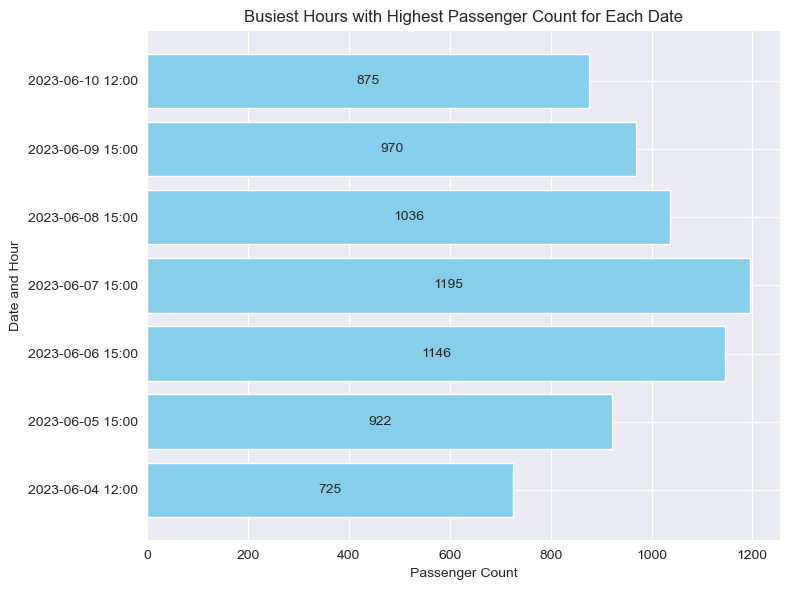

In [656]:
tkt=df.copy()
# Convert 'Transaction Time' to datetime format
tkt['Transaction Time'] = pd.to_datetime(tkt['Transaction Time'])

# Extract hour from 'Transaction Time'
tkt['Hour'] = tkt['Transaction Time'].dt.hour

# Group by date and hour, then sum the passenger count
busiest_hours = tkt.groupby(['Date', 'Hour'])['Passengers'].sum().reset_index()

# Find the hour with the highest passenger count for each date
busiest_hours = busiest_hours.loc[busiest_hours.groupby('Date')['Passengers'].idxmax()]


# Visualize the busiest hours
plt.figure(figsize=(8, 6))
bars = plt.barh(busiest_hours['Date'].astype(str) + ' ' + busiest_hours['Hour'].astype(str) + ':00', busiest_hours['Passengers'], color='skyblue')
plt.ylabel('Date and Hour')
plt.xlabel('Passenger Count')
plt.title('Busiest Hours with Highest Passenger Count for Each Date')

# Add the passenger count labels inside the bars
for index, bar in enumerate(bars):
    plt.text(
        bar.get_width() / 2,  # x-coordinate position of the text (inside the bar)
        bar.get_y() + bar.get_height() / 2,  # y-coordinate position of the text (inside the bar)
        f'{int(bar.get_width())}',  # text to display (passenger count)
        ha='center',  # horizontal alignment
        va='center',  # vertical alignment
        fontsize=10  # font size
    )

plt.tight_layout()
plt.show()


Saturdays and Sundays are busiest around 12 p.m., while other days peak at 3 p.m. Notably, Wednesday, June 7, 2023, saw the highest passenger count at 1,195.

## Table Joins

Merging ticket-type data from E.P. Morris and Ticketer, focusing on retaining all bus stop information. Key columns like 'Ticket Description,' 'Transaction Time,' 'Date,' and 'Trip Number' were standardized for alignment. Duplicate entries were removed to ensure clean, integrated data.

In [661]:
# Bring the Date columns in common format

ticketer['Date'] = pd.to_datetime(ticketer['Date'])
Concess['Date'] = pd.to_datetime(Concess['Date'])



# Perform left join using merge function
ticket_data = pd.merge(ticketer,Concess,on=['Ticket Description','Transaction Time','Date','Trip Number'], how='inner')

ticket_data.head()

,ETM Route Code,Bus Stop,Date,Transaction Time,Ticket Class Description,Trip Number,Ticket Description,Net,Tickets,Pass,...,Number,Fare Paid,Value of Ride,Origin Stage,Destination Stage,Driver number,Bus number,Duty number,Shadow,Custom Formula
0,7,Arundel Road,2023-06-04,05:23:30,Autoscan,1,Adult TOTO,0.0,1,0,...,1,0.0,0,203,273.0,4089,322,3003,2.0,NaN
1,7,Arundel Road,2023-06-04,05:23:34,Autoscan,1,Adult TOTO,0.0,1,0,...,1,0.0,0,203,273.0,4089,322,3003,2.0,NaN
2,7,Arundel Road,2023-06-04,05:23:36,QR,1,M_Adult CitySvr,0.0,0,1,...,1,0.0,0,203,NaN,4089,322,3003,0.0,NaN
3,7,Arundel Road,2023-06-04,05:25:00,Smart,1,BH Ovr60 ENCTS,0.0,0,0,...,1,0.0,0,203,NaN,4089,322,3003,0.0,NaN
4,7,Arundel Road,2023-06-04,05:25:06,Autoscan,1,Adult TOTO,0.0,1,0,...,1,0.0,0,203,38.0,4089,322,3003,2.0,NaN


In [662]:
ticket_data.describe().T

,count,mean,min,25%,50%,75%,max,std
ETM Route Code,75242.0,7.0,7.0,7.0,7.0,7.0,7.0,0.0
Date,75242,2023-06-07 02:17:38.536455680,2023-06-04 00:00:00,2023-06-06 00:00:00,2023-06-07 00:00:00,2023-06-09 00:00:00,2023-06-10 00:00:00,NaN
Trip Number,75242.0,141.397743,1.0,77.0,138.0,194.0,1456.0,95.73485
Net,75242.0,0.214633,0.0,0.0,0.0,0.0,30.0,1.058327
Tickets,75242.0,0.413904,0.0,0.0,0.0,1.0,15.0,0.654762
Pass,75242.0,0.449948,0.0,0.0,0.0,1.0,33.0,1.172522
Conc,75242.0,0.231613,0.0,0.0,0.0,0.0,2.0,0.421992
Passengers,75242.0,1.095465,0.0,1.0,1.0,1.0,33.0,1.099527
Route number,75242.0,7.0,7.0,7.0,7.0,7.0,7.0,0.0
Operator,75242.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The ticket data was then joined with GPS data based on common
fields such as 'Bus Stop', 'Bus Number', and 'Date'. This step aimed to enrich the ticket data with
geographical information.
Redundant or unnecessary columns such as 'Route Number', 'Operator', 'Number', 'Value of Ride',
'Custom Formula', 'ETM Route Code', 'Route Number', and 'Route Description' were dropped. These
columns either contained null values or redundant information.

In [664]:

GPS_df['Date'] = pd.to_datetime(GPS_df['Date'])
model_data = pd.merge(ticket_data, GPS_df, on=['Bus Stop','Bus number','Date'], how='inner')
model_data.head()

,ETM Route Code,Bus Stop,Date,Transaction Time,Ticket Class Description,Trip Number,Ticket Description,Net,Tickets,Pass,...,Route_Desc,Pattern_No,Direction,Timing Point,Location No,Planned Arrival Time,Planned Departure Time,Actual Arrival Time,Actual Departure Time,Dwell time
0,7,Brighton Marina,2023-06-04,05:15:59,QR,1,M_Adult CitySvr,0.0,0,1,...,7,1,1,Timing Point,756(0),05:20:00,05:20:00,1900-01-01 05:20:05,1900-01-01 05:20:05,0
1,7,Brighton Marina,2023-06-04,05:15:59,QR,1,M_Adult CitySvr,0.0,0,1,...,7,1,1,Timing Point,756(0),06:20:00,06:20:00,1900-01-01 06:20:00,1900-01-01 06:20:00,0
2,7,Brighton Marina,2023-06-04,05:16:09,Autoscan,1,Adult TOTO,0.0,1,0,...,7,1,1,Timing Point,756(0),05:20:00,05:20:00,1900-01-01 05:20:05,1900-01-01 05:20:05,0
3,7,Brighton Marina,2023-06-04,05:16:09,Autoscan,1,Adult TOTO,0.0,1,0,...,7,1,1,Timing Point,756(0),06:20:00,06:20:00,1900-01-01 06:20:00,1900-01-01 06:20:00,0
4,7,Brighton Marina,2023-06-04,05:16:23,Smart,1,BH Disab ENCTS,0.0,0,0,...,7,1,1,Timing Point,756(0),05:20:00,05:20:00,1900-01-01 05:20:05,1900-01-01 05:20:05,0


In [665]:
# Drop the specified columns from the DataFrame
model_data.drop(columns=['Route number', 'Operator', 'Number', 'Value of Ride', 
                         'Custom Formula', 'ETM Route Code', 'Route_No', 'Route_Desc'], inplace=True)

The 'Ticket Class Description' column was segmented into five
distinct categories to facilitate analysis:
'Cash' for ticket types 'Adult' and 'Child',
'TOTO' for 'Autoscan' tickets,
'Keycard' for 'Smart' tickets,
'Mobile App' for 'QR' tickets, and
'Others' for various ticket types including 'Passes', 'ALL_ETM', 'OthTkt', 'CSS', 'Excess', and 'Week'.

In [668]:

# Define a function to map the ticket classes to the desired categories
def map_category(ticket_class):
    if ticket_class in ['Adult', 'Child']:
        return 'Cash'
    elif ticket_class == 'Autoscan':
        return 'TOTO'
    elif ticket_class == 'Smart':
        return 'Keycard'
    elif ticket_class == 'QR':
        return 'Mobile App'
    elif ticket_class in ['Passes','ALL_ETM','OthTkt','CSS','Excess','Week']:
        return 'Others'
    else:
        return None  # or whatever default value you prefer

# Create new columns based on the mapping
model_data['Cash'] = model_data['Ticket Class Description'].apply(lambda x: x if map_category(x) == 'Cash' else None)
model_data['TOTO'] = model_data['Ticket Class Description'].apply(lambda x: x if map_category(x) == 'TOTO' else None)
model_data['Keycard'] = model_data['Ticket Class Description'].apply(lambda x: x if map_category(x) == 'Keycard' else None)
model_data['Mobile App'] = model_data['Ticket Class Description'].apply(lambda x: x if map_category(x) == 'Mobile App' else None)
model_data['Others'] = model_data['Ticket Class Description'].apply(lambda x: x if map_category(x) == 'Others' else None)
# Drop the original 'Ticket Class Description' column
#model_data.drop(columns=['Ticket Class Description'], inplace=True)

# Display the resulting DataFrame
print(model_data)


               Bus Stop       Date Transaction Time Ticket Class Description  \
0       Brighton Marina 2023-06-04         05:15:59                       QR   
1       Brighton Marina 2023-06-04         05:15:59                       QR   
2       Brighton Marina 2023-06-04         05:16:09                 Autoscan   
3       Brighton Marina 2023-06-04         05:16:09                 Autoscan   
4       Brighton Marina 2023-06-04         05:16:23                    Smart   
...                 ...        ...              ...                      ...   
456787   Wilbury Villas 2023-06-10         22:34:13                       QR   
456788   Wilbury Villas 2023-06-10         23:17:49                 Autoscan   
456789   Wilbury Villas 2023-06-10         23:17:49                 Autoscan   
456790   Wilbury Villas 2023-06-10         23:17:49                 Autoscan   
456791   Wilbury Villas 2023-06-10         23:17:49                 Autoscan   

        Trip Number Ticket Description 

# Modeling

In [725]:
model_data['Actual Arrival Time'] = model_data['Actual Arrival Time'].dt.time
model_data['Actual Departure Time'] = model_data['Actual Departure Time'].dt.time

AttributeError: Can only use .dt accessor with datetimelike values

In [727]:

# List the columns you want to convert to integer type
columns_to_convert = ['Net','Fare Paid','Origin Stage','Shadow','Planned Arrival Time','Planned Departure Time',
                    'Actual Arrival Time','Actual Departure Time']
# Convert the specified columns to integer type
model_data[columns_to_convert] =model_data[columns_to_convert].astype(int)

# After converting, you can check the data types using the info() method
model_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456792 entries, 0 to 456791
Data columns (total 33 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Bus Stop                  456792 non-null  int64         
 1   Date                      456792 non-null  datetime64[ns]
 2   Transaction Time          456792 non-null  object        
 3   Ticket Class Description  456792 non-null  int64         
 4   Trip Number               456792 non-null  int64         
 5   Ticket Description        456792 non-null  int64         
 6   Net                       456792 non-null  int32         
 7   Tickets                   456792 non-null  int64         
 8   Pass                      456792 non-null  int64         
 9   Conc                      456792 non-null  int64         
 10  Passengers                456792 non-null  int64         
 11  Fare Paid                 456792 non-null  int32         
 12  Or

### Encoding

In [735]:

from sklearn.preprocessing import LabelEncoder

# Define columns to encode
columns_to_encode = ['Ticket Class Description','Ticket Description', 'TOTO', 'Cash', 'Keycard', 'Mobile App', 'Others',
                     'Timing Point', 'Bus Stop','Location No','Planned Arrival Time','Planned Departure Time',
                    'Actual Arrival Time','Actual Departure Time','Transaction Time']

# Create LabelEncoder instance
label_encoder = LabelEncoder()

# Apply LabelEncoder to each specified column
for column in columns_to_encode:
    model_data[column] = label_encoder.fit_transform(model_data[column])
    

### Correlation

In [737]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456792 entries, 0 to 456791
Data columns (total 33 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Bus Stop                  456792 non-null  int64         
 1   Date                      456792 non-null  datetime64[ns]
 2   Transaction Time          456792 non-null  int32         
 3   Ticket Class Description  456792 non-null  int64         
 4   Trip Number               456792 non-null  int64         
 5   Ticket Description        456792 non-null  int64         
 6   Net                       456792 non-null  int32         
 7   Tickets                   456792 non-null  int64         
 8   Pass                      456792 non-null  int64         
 9   Conc                      456792 non-null  int64         
 10  Passengers                456792 non-null  int64         
 11  Fare Paid                 456792 non-null  int32         
 12  Or

C:\Users\ashra\AppData\Local\Temp\ipykernel_15144\1124149236.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dwell_time_correlation.values, y=dwell_time_correlation.index, palette="viridis")


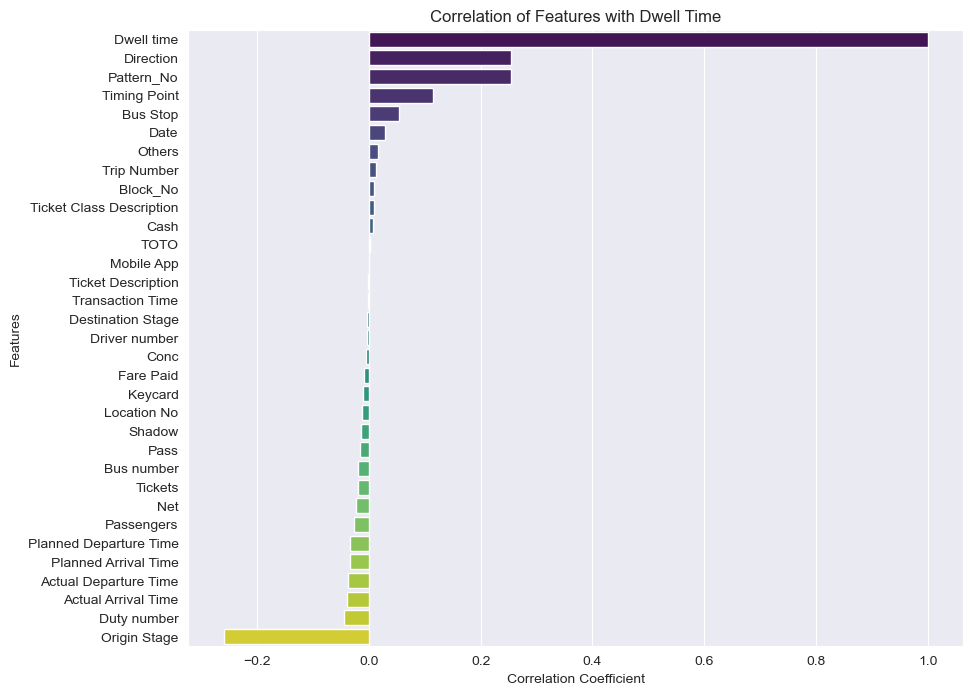

In [739]:
correlation_matrix = model_data.corr()

# Extract and sort the correlation of all columns with 'Dwell time'
dwell_time_correlation = correlation_matrix['Dwell time'].sort_values(ascending=False)

# Plot the sorted correlation values
plt.figure(figsize=(10, 8))
sns.barplot(x=dwell_time_correlation.values, y=dwell_time_correlation.index, palette="viridis")

# Add titles and labels
plt.title('Correlation of Features with Dwell Time')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')

# Show the plot
plt.show()



### Nested Machine Learning Model - KNN, XGBoost, Random Forest

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Split data into train and test sets
X = model_data[['Mobile App','TOTO','Cash','Keycard','Others','Passengers',
                'Timing Point','Origin Stage','Direction','Bus Stop',
                'Actual Arrival Time','Actual Departure Time']]
y = model_data['Dwell time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regression": RandomForestRegressor(),
    "XGBoost Regression": XGBRegressor(),
    "KNeighbor Regression": KNeighborsRegressor(n_neighbors=5)
}
    
    
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} Metrics:")
    print(f"  Mean Squared Error: {mse:.2f}")
    print(f"  Root Mean Squared Error: {rmse:.2f}")
    print(f"  Mean Absolute Error: {mae:.2f}")
    print(f"  R-squared: {r2:.2f}")
    print()    


Linear Regression Metrics:
  Mean Squared Error: 922.69
  Root Mean Squared Error: 30.38
  Mean Absolute Error: 20.70
  R-squared: 0.15

Random Forest Regression Metrics:
  Mean Squared Error: 5.89
  Root Mean Squared Error: 2.43
  Mean Absolute Error: 0.41
  R-squared: 0.99

XGBoost Regression Metrics:
  Mean Squared Error: 373.69
  Root Mean Squared Error: 19.33
  Mean Absolute Error: 12.93
  R-squared: 0.66

KNeighbor Regression Metrics:
  Mean Squared Error: 20.51
  Root Mean Squared Error: 4.53
  Mean Absolute Error: 1.01
  R-squared: 0.98



80% of the data was allocated for training, while the remaining
20% was designated for testing. This partitioning strategy was implemented to assess and contrast the
performance of Linear Regression, KNN, XGBoost, and Random Forest regression models.Based on the provided performance metrics, the Random Forest Regression model outperforms the
other models in terms of MSE, RMSE, and MAE, with significantly lower values indicating better
accuracy. It also exhibits the highest R-squared value, suggesting a better fit to the data compared to
the other models. The XGBoost Regression model performs reasonably well with relatively low MSE and
RMSE values, but it has a higher MAE and lower R-squared compared to the Random Forest Regression.
The Linear Regression model shows the poorest performance, with the highest MSE, RMSE, and MAE,
and the lowest R-squared value, indicating a weaker fit to the data. The K-Nearest Neighbors Regression
model performs moderately well but has slightly higher MSE, RMSE, and MAE compared to the Random
Forest and XGBoost models, and a slightly lower R-squared value. Overall, the Random Forest
Regression model appears to be the most suitable for the given dataset based on the provided
performance metrics.
In addition to the comparison, it's evident that Linear Regression is not well-suited for this dataset as it
exhibits the poorest performance across all metrics. With substantially higher values of MSE, RMSE, and
MAE, and the lowest R-squared value among all models, Linear Regression fails to adequately capture
the underlying relationships in the data. This indicates that the linear assumption may not hold true for
this dataset, leading to a poor fit and inaccurate predictions. Therefore, more complex models like
Random Forest Regression and XGBoost Regression, which can capture nonlinear relationships, are
preferred for this dataset.

### Cross-Validation - KNN, XGBoost, Random Forest

In [48]:
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
import numpy as np

# Split data into train and test sets
X = model_data[['Mobile App','TOTO','Cash','Keycard','Others','Passengers',
                'Timing Point','Origin Stage','Direction','Bus Stop',
                'Actual Arrival Time','Actual Departure Time']]
y = model_data['Dwell time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define regression models
models = {
    "Random Forest Regression": RandomForestRegressor(),
    "XGBoost Regression": XGBRegressor(),
    "KNeighbor Regression": KNeighborsRegressor(n_neighbors=5)
}
    
# Perform k-fold cross-validation for each model
for name, model in models.items():
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Perform 5-fold cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    
    # Convert negative MSE scores to positive
    scores = -scores
    
    # Calculate mean MSE and standard deviation
    mean_mse = scores.mean()
    std_mse = scores.std()
    
    # Calculate RMSE
    rmse = np.sqrt(mean_mse)
    
    # Calculate MAE
    mae = mean_absolute_error(y_test, model.predict(X_test))
    
    # Calculate R-squared
    r2 = model.score(X_test, y_test)
    
    # Print results
    print(f"{name}:\n")
    print(f"\tMean Squared Error: {mean_mse:.2f}")
    print(f"\tRoot Mean Squared Error: {rmse:.2f}")
    print(f"\tMean Absolute Error: {mae:.2f}")
    print(f"\tR-squared: {r2:.2f}\n")


Random Forest Regression:

	Mean Squared Error: 9.87
	Root Mean Squared Error: 3.14
	Mean Absolute Error: 0.42
	R-squared: 0.99

XGBoost Regression:

	Mean Squared Error: 374.96
	Root Mean Squared Error: 19.36
	Mean Absolute Error: 12.93
	R-squared: 0.66

KNeighbor Regression:

	Mean Squared Error: 32.15
	Root Mean Squared Error: 5.67
	Mean Absolute Error: 1.01
	R-squared: 0.98



The three machine learning models underwent a 5-fold crossvalidation process. This approach offers a comprehensive assessment of model performance and
mitigates the risk of overfitting (Ng, 1998) , maximising data utility, reducing bias, distinguishing it from
the traditional method of building models individually (Moreno-Torres et al., 2012).Cross-validation results confirm the Random Forest Regression model as the top performer, with the lowest MSE, RMSE, and MAE, and the highest R-squared, indicating a strong fit and reliability. In comparison, the XGBoost and K-Nearest Neighbors models show higher error metrics and lower R-squared values, indicating less robust performance. Overall, Random Forest stands out as the best model for generalizing to new data.

# Feature Importance

In [53]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

# Define feature names
feature_names = ['Mobile App', 'TOTO', 'Cash', 'Keycard', 'Others', 'Passengers',
                 'Timing Point', 'Origin Stage', 'Direction', 'Bus Stop',
                 'Actual Arrival Time', 'Actual Departure Time']

# Split data into train and test sets
X = model_data[feature_names]
y = model_data['Dwell time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the Random Forest model
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# Get feature importances from the model
rf_feature_importances = rf.feature_importances_

# Creating a DataFrame for better visualization
rf_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_feature_importances
}).sort_values(by='Importance', ascending=False)

print("Random Forest Feature Importances:")
print(rf_importances_df)

Random Forest Feature Importances:
                  Feature  Importance
11  Actual Departure Time    0.335534
10    Actual Arrival Time    0.317356
9                Bus Stop    0.247154
6            Timing Point    0.065953
7            Origin Stage    0.019289
8               Direction    0.012303
5              Passengers    0.000839
2                    Cash    0.000377
0              Mobile App    0.000339
1                    TOTO    0.000315
3                 Keycard    0.000290
4                  Others    0.000251


"# Plot feature importances\nplt.figure(figsize=(10, 6))\nplt.barh(rf_importances_df['Feature'], rf_importances_df['Importance'])\nplt.xlabel('Importance')\nplt.ylabel('Feature')\nplt.title('Random Forest Feature Importances')\nplt.gca().invert_yaxis()  # To display the highest importance at the top\nplt.show()\n"

In [54]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

# Define feature names
feature_names = ['Mobile App', 'TOTO', 'Cash', 'Keycard', 'Others', 'Passengers',
                 'Timing Point', 'Origin Stage', 'Direction', 'Bus Stop',
                 'Actual Arrival Time', 'Actual Departure Time']

# Split data into train and test sets
X = model_data[feature_names]
y = model_data['Dwell time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the XGBoost model
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

# Get feature importances from the model
xgb_feature_importances = xgb.feature_importances_

# Creating a DataFrame for better visualization
xgb_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_feature_importances
}).sort_values(by='Importance', ascending=False)

print("XGBoost Feature Importances:")
print(xgb_importances_df)

XGBoost Feature Importances:
                  Feature  Importance
9                Bus Stop    0.326210
6            Timing Point    0.242614
11  Actual Departure Time    0.158655
10    Actual Arrival Time    0.109854
7            Origin Stage    0.076621
8               Direction    0.058170
2                    Cash    0.009206
5              Passengers    0.007685
4                  Others    0.004076
1                    TOTO    0.002369
0              Mobile App    0.002301
3                 Keycard    0.002239


'# Plot feature importances\nplot_importance(xgb)\nplt.show()'

In [57]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import pandas as pd

# Define feature names
feature_names = ['Mobile App', 'TOTO', 'Cash', 'Keycard', 'Others', 'Passengers',
                 'Timing Point', 'Origin Stage', 'Direction', 'Bus Stop',
                 'Actual Arrival Time', 'Actual Departure Time']

# Split data into train and test sets
X = model_data[feature_names]
y = model_data['Dwell time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the KNN model
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

# Calculate permutation importance
knn_perm_importance = permutation_importance(knn, X_train, y_train, n_repeats=10, random_state=42)

# Creating a DataFrame for better visualization
knn_perm_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': knn_perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

print("KNN Permutation Importances:")
print(knn_perm_importances_df)


KNN Permutation Importances:
                  Feature    Importance
10    Actual Arrival Time  4.623626e+01
11  Actual Departure Time  4.573206e+01
7            Origin Stage  3.953130e-01
9                Bus Stop  8.699333e-02
5              Passengers  1.446450e-04
8               Direction  7.090341e-06
0              Mobile App  4.708888e-06
4                  Others  2.630182e-06
6            Timing Point  1.995586e-06
2                    Cash  1.365233e-06
1                    TOTO  3.484436e-07
3                 Keycard -5.694959e-08


Analysis of feature importance across Random Forest, XGBoost, and KNN models reveals key patterns. In Random Forest, actual departure time, actual arrival time, and bus stop were the most significant features, while XGBoost highlighted bus stop and timing point. KNN emphasized arrival and departure times. Across all models, features like cash, TOTO, keycard, and mobile app showed minimal importance, likely due to the quick, uniform transaction times or low dataset variability for these payment types. This suggests that factors like traffic and boarding procedures play a greater role in predicting dwell time.Note that, all these assumptions
needed to check with data provider or domain expert

# Reference

Ng, A. (1998). Preventing "Overfitting" of Cross-Validation Data. Proceedings of the Fourteenth
International Conference on Machine Learning.


Moreno-Torres, J., Sáez, J. A., & Herrera, F. (2012). Study on the Impact of Partition-Induced Dataset
Shift on k-Fold Cross-Validation. IEEE Transactions on Neural Networks and Learning Systems, 23, 1304-
1312. DOI: 10.1109/TNNLS.2012.2199516.